In [0]:
import matplotlib.pyplot as plt, numpy as np, os, re, time, tensorflow as tf, unicodedata
from google.colab import files
tf.enable_eager_execution()

In [2]:
# removing all existing files
files_in_directory = [file for file in os.listdir('.') if os.path.isfile(os.path.join('.', file))]
for counter in files_in_directory:
    os.remove(counter)

# uploading file
uploaded = files.upload()

Saving fra.txt to fra.txt


In [0]:
# removing the accents
def unicode_to_ascii(string):
    return ''.join(character for character in unicodedata.normalize('NFD', string) if unicodedata.category(character) != 'Mn')

# cleaning a sentence
def preprocess_sentence(line):
    # converting from unicode to ascii
    line = unicode_to_ascii(line.lower().strip())

    # creating a space between a word and the punctuation following it, and then collapsing multiple spaces
    line = re.sub(r"([!',-.0-9?])", r" \1 ", line)
    line = re.sub(r'[" "]+', " ", line)

    # replacing everything with space except a-z, A-Z, "!", "'", ",", "-", ".", 0-9, "?"
    line = re.sub(r"[^a-zA-Z!',-.0-9?]+", " ", line).strip()

    # adding a start and an end token to the sentence
    line = '<start> ' + line + ' <end>'

    return line

# creating line pairs in the format: [target, source]
def create_dataset(filepath, size):
    # open the file as read only, read all text and split in lines
    pairs = open(filepath, mode = 'rt', encoding='UTF-8').read().strip().split('\n')

    # reducing dataset, splitting into target - source pairs and cleaning
    line_pairs = [[preprocess_sentence(line) for line in pair.split('\t')] for pair in pairs[:size]]

    return line_pairs

# creating a class for word -> index mapping
class LanguageIndex():
    def __init__(self, language):
        self.language = language
        self.word_to_index = {}
        self.index_to_word = {}
        self.vocabulary = set()
        self.create_index()

    def create_index(self):
        for phrase in self.language:
            self.vocabulary.update(phrase.split(' '))

        self.vocabulary = sorted(self.vocabulary)

        self.word_to_index['<pad>'] = 0
        for index, word in enumerate(self.vocabulary):
            self.word_to_index[word] = index + 1

        for word, index in self.word_to_index.items():
            self.index_to_word[index] = word

# finding maximum sentence length
def maximum_length(lines):
    return max(len(line.split()) for line in lines)

def maximum_length(tensor):
    return max(len(element) for element in tensor)

# loading dataset in required format
def load_dataset(filepath, size):
    # creating cleaned input, output pairs
    pairs = create_dataset(filepath, size)

    # index language using the class defined above    
    source_language = LanguageIndex(source for target, source in pairs)
    target_language = LanguageIndex(target for target, source in pairs)

    # vectorising the input and target languages
    input_tensor = [[source_language.word_to_index[sentence] for sentence in source.split(' ')] for target, source in pairs]
    target_tensor = [[target_language.word_to_index[sentence] for sentence in target.split(' ')] for target, source in pairs]

    # calculating maximum length of input and output tensor, which we will set to the longest sentence in the dataset
    maximum_length_source, maximum_length_target = maximum_length(input_tensor), maximum_length(target_tensor)
    
    # padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen = maximum_length_source, padding = 'post')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen = maximum_length_target, padding = 'post')
    
    return pairs, input_tensor, target_tensor, source_language, target_language, maximum_length_source, maximum_length_target

# loading reduced dataset
reduced_size = 35000
data, dataX, dataY, vocabX, vocabY, sizeX, sizeY = load_dataset('fra.txt', reduced_size)

BATCH_SIZE = 64
embedding_dimension = 256
units = 1024
vocabulary_source_size = len(vocabX.word_to_index)
vocabulary_target_size = len(vocabY.word_to_index)

dataset = tf.data.Dataset.from_tensor_slices((dataX, dataY)).shuffle(len(dataX))
dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(BATCH_SIZE))

In [0]:
def gru(units):
    return tf.keras.layers.CuDNNGRU(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

class Encoder(tf.keras.Model):
    def __init__(self, vocabulary_size, embedding_dimension, encoder_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_units = encoder_units
        self.embedding = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension)
        self.gru = gru(self.encoder_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoder_units))

class Decoder(tf.keras.Model):
    def __init__(self, vocabulary_size, embedding_dimension, decoder_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.decoder_units = decoder_units
        self.embedding = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension)
        self.gru = gru(self.decoder_units)
        self.fc = tf.keras.layers.Dense(vocabulary_size)

        # used for attention
        self.W1 = tf.keras.layers.Dense(self.decoder_units)
        self.W2 = tf.keras.layers.Dense(self.decoder_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, encoder_output):
        # encoder_output shape == (batch_size, max_length, hidden_size)

        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, hidden_size)
        score = tf.nn.tanh(self.W1(encoder_output) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis = 1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis = 1)

        # x shape after passing through embedding == (batch_size, 1, embedding_dimension)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dimension + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc(output)

        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.decoder_units))

encoder = Encoder(vocabulary_source_size, embedding_dimension, units, BATCH_SIZE)
decoder = Decoder(vocabulary_target_size, embedding_dimension, units, BATCH_SIZE)

In [5]:
optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = real, logits = pred) * mask
    return tf.reduce_mean(loss_)

EPOCHS = 20

past_loss = 0
counter = 0

for epoch in range(EPOCHS):
    tic = time.time()

    hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (X, Y)) in enumerate(dataset):
        loss = 0

        with tf.GradientTape() as tape:
            encoder_output, encoder_hidden = encoder(X, hidden)
            decoder_hidden = encoder_hidden
            decoder_input = tf.expand_dims([vocabY.word_to_index['<start>']] * BATCH_SIZE, 1)

            # using teacher forcing
            for t in range(1, Y.shape[1]):
                # passing encoder_output to the decoder
                predictions, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_output)
                loss += loss_function(Y[:, t], predictions)

                # feeding the target as the next input
                decoder_input = tf.expand_dims(Y[:, t], 1)

        total_loss += (loss / int(Y.shape[1]))
        variables = encoder.variables + decoder.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables), tf.train.get_or_create_global_step())

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch + 1, loss.numpy() / int(Y.shape[1])))

    toc = time.time()

    present_loss = total_loss / len(dataX)
    print('Epoch {} Loss {:.4f} Time taken {:.2f} seconds'.format(epoch + 1, present_loss, toc - tic))

    if past_loss - present_loss >= 0.001:
        past_loss = present_loss
    else:
        past_loss = present_loss
        counter += 1

    if counter == 5:
        print("\nEarrlystopping at {} th epoch".format(epoch + 1))
        break

Epoch 1 Batch 1 Loss 4.2327
Epoch 1 Batch 101 Loss 1.7143
Epoch 1 Batch 201 Loss 1.4096
Epoch 1 Batch 301 Loss 1.2208
Epoch 1 Batch 401 Loss 1.0691
Epoch 1 Batch 501 Loss 1.0045
Epoch 1 Loss 0.0220 Time taken 189.91 seconds
Epoch 2 Batch 1 Loss 0.8665
Epoch 2 Batch 101 Loss 0.8424
Epoch 2 Batch 201 Loss 0.7073
Epoch 2 Batch 301 Loss 0.7018
Epoch 2 Batch 401 Loss 0.7161
Epoch 2 Batch 501 Loss 0.5910
Epoch 2 Loss 0.0112 Time taken 188.88 seconds
Epoch 3 Batch 1 Loss 0.5171
Epoch 3 Batch 101 Loss 0.4124
Epoch 3 Batch 201 Loss 0.4400
Epoch 3 Batch 301 Loss 0.3537
Epoch 3 Batch 401 Loss 0.4554
Epoch 3 Batch 501 Loss 0.4225
Epoch 3 Loss 0.0068 Time taken 189.01 seconds
Epoch 4 Batch 1 Loss 0.2380
Epoch 4 Batch 101 Loss 0.2739
Epoch 4 Batch 201 Loss 0.3320
Epoch 4 Batch 301 Loss 0.3084
Epoch 4 Batch 401 Loss 0.2507
Epoch 4 Batch 501 Loss 0.3235
Epoch 4 Loss 0.0046 Time taken 189.20 seconds
Epoch 5 Batch 1 Loss 0.2216
Epoch 5 Batch 101 Loss 0.2102
Epoch 5 Batch 201 Loss 0.1729
Epoch 5 Batch 30

Source: <start> va ! <end>
Result: go . <end> 
Target: go . <end> 

Source: <start> remets - le en place ! <end>
Result: hand it back . <end> 
Target: put it back . <end> 

Source: <start> j ' ai fini par l ' emporter . <end>
Result: i finally won . <end> 
Target: i finally won . <end> 

Source: <start> j ' ai vu le match . <end>
Result: i saw the game . <end> 
Target: i saw the game . <end> 

Source: <start> il me faut me battre . <end>
Result: i need to fight . <end> 
Target: i have to fight . <end> 

Source: <start> telephonez au 1 1 0 immediatement . <end>
Result: dial 1 1 0 at once . <end> 
Target: dial 1 1 0 at once . <end> 

Source: <start> ils vont faire des emplettes . <end>
Result: they go shopping . <end> 
Target: they go shopping . <end> 

Source: <start> je vous ai laisse une note . <end>
Result: i let you a note . <end> 
Target: i left you a note . <end> 

Source: <start> qui a fait cette tarte ? <end>
Result: who made this pie ? <end> 
Target: who made this pie ? <end> 


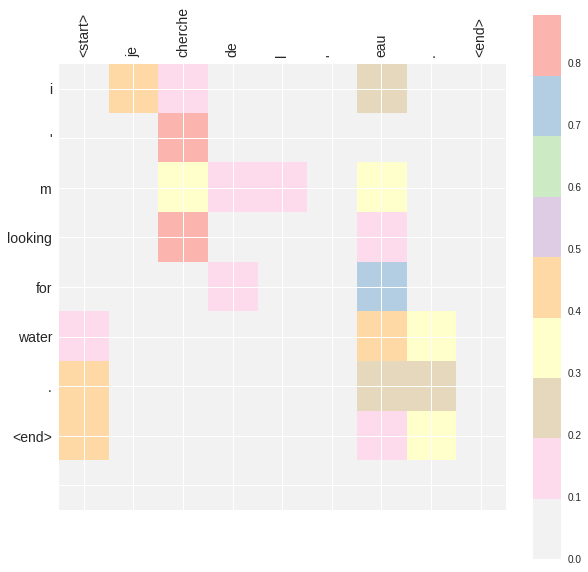

In [6]:
def evaluate(sentence, ENCODER, DECODER, source_language, target_language, maximum_length_source, maximum_length_target):
    attention_plot = np.zeros((maximum_length_target, maximum_length_source))

    sentence = preprocess_sentence(sentence)
    inputs = [source_language.word_to_index[word] for word in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen = maximum_length_source, padding = 'post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    encoder_output, encoder_hidden = ENCODER(inputs, hidden)
    decoder_hidden = encoder_hidden
    decoder_input = tf.expand_dims([target_language.word_to_index['<start>']], 0)

    for counter in range(maximum_length_target):
        predictions, decoder_hidden, attention_weights = DECODER(decoder_input, decoder_hidden, encoder_output)

        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[counter] = attention_weights.numpy()

        predicted_id = tf.multinomial(tf.exp(predictions), num_samples = 1)[0][0].numpy()
        result += target_language.index_to_word[predicted_id] + ' '

        if target_language.index_to_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        decoder_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    figure = plt.figure(figsize = (10, 10))
    axis = figure.add_subplot(1, 1, 1)
    image = axis.matshow(attention, cmap = 'Pastel1_r')
    figure.colorbar(image)
    fontdict = {'fontsize': 14}
    axis.set_xticklabels([''] + sentence, fontdict = fontdict, rotation = 90)
    axis.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)
    plt.show()

# translating and plotting attention
def translate(source, ENCODER, DECODER, source_language, target_language, maximum_length_source, maximum_length_target, plot = False):
    result, source, attention_plot = evaluate(source, ENCODER, DECODER, source_language, target_language, maximum_length_source, maximum_length_target)

    print('Source: {}'.format(source))
    print('Result: {}'.format(result))

    if plot == True:
        attention_plot = attention_plot[:len(result.split(' ')), :len(source.split(' '))]
        plot_attention(attention_plot, source.split(' '), result.split(' '))

# showing examples of model performance
for counter, language_pair in enumerate(data):
    if counter % 2500 == 0:
        translate(language_pair[1][len('<start> ') : -len(' <end>')], encoder, decoder, vocabX, vocabY, sizeX, sizeY)
        print('Target: {} \n'.format(language_pair[0][len('<start> '):]))

# showing attention plot
print('_' * 75, '\n')
translate("Je cherche de l'eau.", encoder, decoder, vocabX, vocabY, sizeX, sizeY, True)